       Time        x0        x1
0  0.000000  1.000000  1.000000
1  0.050003  1.089604  0.554162
2  0.100005  1.166195  0.237215
3  0.150008  1.171996  0.055501
4  0.200010  1.176839 -0.024131


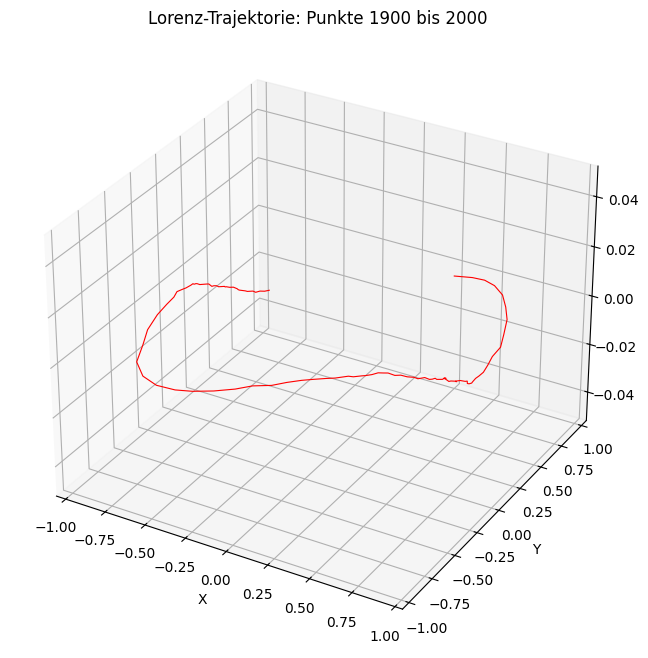

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# CSV-Datei einlesen
file_path = 'D:\Master_EI\FP\Modeling_Dynamic_Systems\DynSys_and_DataSets\\van-der-pol-stochastic\\van_der_pol_stochastic_data_2.csv'  # Ersetze dies durch deinen Dateinamen
data = pd.read_csv(file_path)

# Daten anzeigen (optional)
print(data.head())

# Benutzerdefinierter Bereich für die Trajektorie
start_index = 1900  # Startindex der Sequenz
end_index = 2000   # Endindex der Sequenz
sequence = data.iloc[start_index:end_index]

# Extrahiere X, Y, Z-Koordinaten
x_seq = sequence['x0']
y_seq = sequence['x1']


# Plotten der ausgewählten Sequenz
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_seq, y_seq, lw=0.8, color='r')

# Achsentitel und Labels
ax.set_title(f"Lorenz-Trajektorie: Punkte {start_index} bis {end_index}")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

       Time          X          Y          Z
0  0.000000  10.000000  10.000000  10.000000
1  0.005000  10.020721  10.839069  10.385594
2  0.010001  10.080835  11.657278  10.809549
3  0.015001  10.177437  12.455817  11.272949
4  0.020001  10.307804  13.235280  11.777163


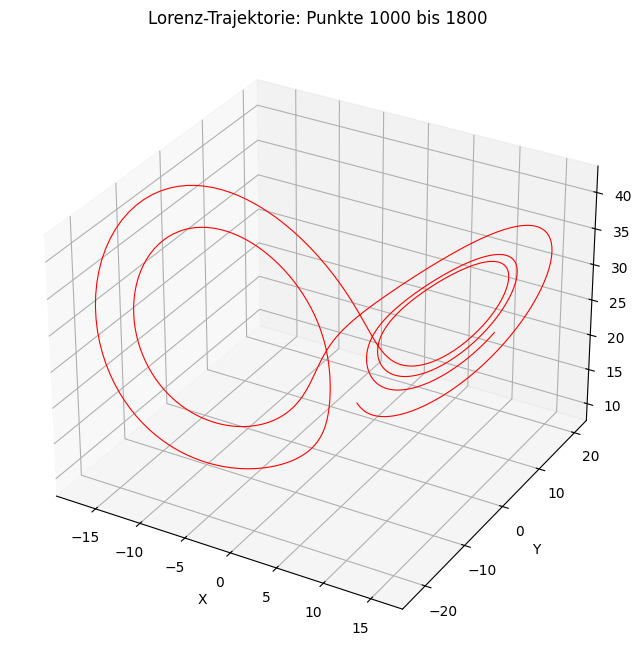

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# CSV-Datei einlesen
file_path = 'D:\Master_EI\FP\Modeling_Dynamic_Systems\DynSys_and_DataSets\lorenz_system\lorenz_system_data_1.csv'  # Ersetze dies durch deinen Dateinamen
data = pd.read_csv(file_path)

# Daten anzeigen (optional)
print(data.head())

# Benutzerdefinierter Bereich für die Trajektorie
start_index = 1000  # Startindex der Sequenz
end_index = 1800   # Endindex der Sequenz
sequence = data.iloc[start_index:end_index]

# Extrahiere X, Y, Z-Koordinaten
x_seq = sequence['X']
y_seq = sequence['Y']
z_seq = sequence['Z']

# Plotten der ausgewählten Sequenz
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_seq, y_seq, z_seq, lw=0.8, color='r')

# Achsentitel und Labels
ax.set_title(f"Lorenz-Trajektorie: Punkte {start_index} bis {end_index}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
